# Training an MLP using UKF/EKF

In [82]:
import jax
import flax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax import linen as nn
from jax.random import PRNGKey, normal, split
from tqdm.notebook import tqdm

In [20]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

$$
    y=x + 2\cos(x)(-5)\sin(x) + x^3
$$

In [94]:
def f(x): return x -10 * jnp.cos(x) * jnp.sin(x) + x ** 3

In [95]:
key = PRNGKey(314)
key_x, key_y = split(key, 2)
noise_y = normal(key, (n_obs, ))

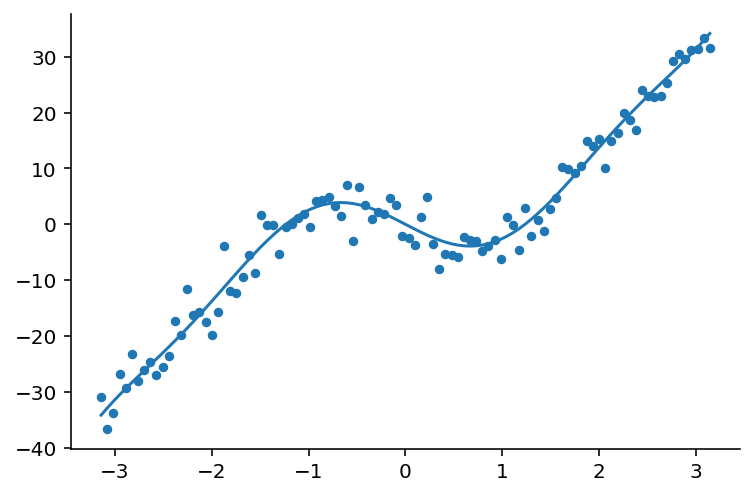

In [96]:
n_obs = 100
x = jnp.linspace(-jnp.pi, jnp.pi, n_obs)
y = f(x) + noise_y * 3

plt.plot(x, f(x))
plt.scatter(x, y, s=14)

## MLP

In [332]:
import typing

In [533]:
class MLP1D(nn.Module):
    n_hidden: int
        
    def setup(self):
        self.layer1 = nn.Dense(self.n_hidden)
        self.layer2 = nn.Dense(self.n_hidden)
        self.layer_out = nn.Dense(1)
    
    def __call__(self, x):
        x = x[:, None]
        x = nn.sigmoid(self.layer1(x))
        x = nn.sigmoid(self.layer2(x))
        x = self.layer_out(x)
        return x

In [534]:
def make_mse(x_batch, y_batch):
    def mse(params):
        def squared_error(x, y):
            yhat = model.apply(params, x)
            err = y - yhat
            return jnp.inner(err, err) / 2.0
        return jnp.mean(jax.vmap(squared_error)(x_batch, y_batch), axis=0).ravel()[0]
    return jax.jit(mse)

loss = make_mse(x[:,None], y)

In [535]:
key = PRNGKey(314)
key1, key2 = split(key, 2)

model = MLP1D(10)
params = model.init(key1, x)
yhat = model.apply(params, x)

In [536]:
yhat = model.apply(params, x)
err = (y[:, None] - yhat)
jnp.linalg.norm(err, 2) ** 2 / (2 * len(x))

DeviceArray(123.50313, dtype=float32)

In [537]:
alpha = 0.1
grad_fn = jax.value_and_grad(loss)
pb = tqdm(range(2000))
for i in pb:
    loss_val, grads =  grad_fn(params)
    params = jax.tree_multimap(lambda p, g: p - alpha * g, params, grads)
    if i % 100 == 0:
        desc = f"Loss step {i:03}: {loss_val:0.2f}"
        pb.set_description_str(desc)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [538]:
xtest = jnp.linspace(-jnp.pi, jnp.pi, 200)
yhat_test = model.apply(params, xtest)

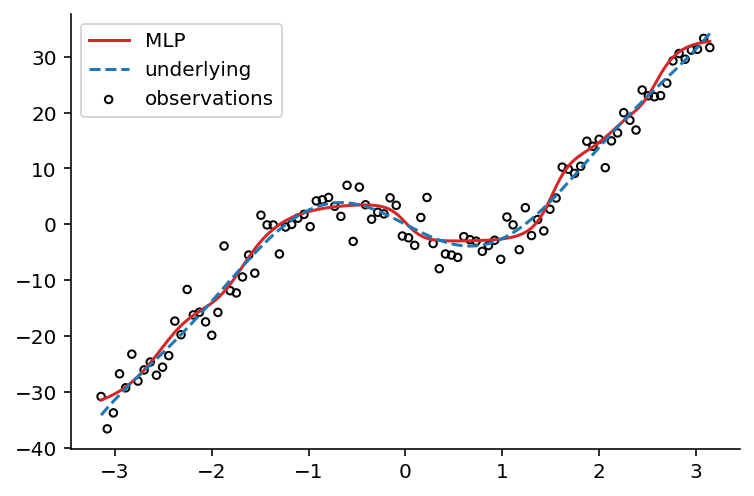

In [539]:
plt.plot(xtest, yhat_test, c="tab:red", label="MLP")
plt.plot(x, f(x), label="underlying", linestyle="--")
plt.scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
plt.legend()

In [ ]:
# This doesn't work
Hw = jax.jacobian(model)
Hw(x)

# UKF Method

In [541]:
W0 = jax.tree_map(lambda p: p * 0, params)

In [542]:
jax.tree_map(lambda p: p.shape, params)

FrozenDict({
    params: {
        layer1: {
            bias: (10,),
            kernel: (1, 10),
        },
        layer2: {
            bias: (10,),
            kernel: (10, 10),
        },
        layer_out: {
            bias: (1,),
            kernel: (10, 1),
        },
    },
})

In [491]:
def fz(W): return W
def fx(W, x): return model.apply(params, x)

In [492]:
fx(params, x[0, None])

DeviceArray([[-31.426058]], dtype=float32)

In [505]:
leafs, treedef = jax.tree_util.tree_flatten(params)

In [ ]:
jax.tree_unflatten(treedef, leafs)


In [543]:
leafs, treedef = jax.tree_util.tree_flatten(params)
shapes = [leaf.shape for leaf in leafs]

In [544]:
all_params = jax.tree_map(lambda v: v.reshape(-1, 1), leafs)
all_params = jnp.concatenate(all_params)
all_params.shape 

(141, 1)

In [545]:
import numpy as np

In [546]:
indices = jnp.array([np.prod(s) for s in shapes]).cumsum()

In [547]:
split_reconstruction = jnp.array_split(all_params, indices)
split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
params_reconstructed = jax.tree_unflatten(treedef, split_reconstruction)

In [552]:
def sqrtm(M):
    """
    Compute the matrix square-root of a hermitian
    matrix M. i,e, R such that RR = M

    Parameters
    ----------
    M: array(m, m)
        Hermitian matrix

    Returns
    -------
    array(m, m): square-root matrix
    """
    evals, evecs = jnp.linalg.eigh(M)
    R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
    return R

In [554]:
n_params, _ = all_params.shape
Sigma0 = jnp.eye(n_params)
Sigma_half = sqrtm(Sigma0)
Sigma_half

DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
             [0., 1., 0., ..., 0., 0., 0.],
             [0., 0., 1., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 1., 0., 0.],
             [0., 0., 0., ..., 0., 1., 0.],
             [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [557]:
shapes

[(10,), (1, 10), (10,), (10, 10), (1,), (10, 1)]

In [563]:
model.apply(params_reconstructed, x[1, None])

DeviceArray([[-30.987345]], dtype=float32)

In [622]:
def forward_mlp(X, params_flat, model, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    yhat = model.apply(params, X)
    return yhat

In [607]:
forward_mlp(x[1, None],  all_params, model, shapes, treedef)

DeviceArray([[-30.987345]], dtype=float32)

In [825]:
class UnscentedKalmanFilter:
    """
    Implementation of the Unscented Kalman Filter for discrete time systems
    """
    def __init__(self, fz, fx, Q, R, alpha, beta, kappa):
        self.fz = fz
        self.fx = fx
        self.Q = Q
        self.R = R
        self.d, _ = Q.shape
        self.alpha = alpha
        self.beta = beta
        self.kappa = kappa
        self.lmbda = alpha ** 2 * (self.d + kappa) - self.d
        self.gamma = jnp.sqrt(self.d + self.lmbda)
    
    @staticmethod
    def sqrtm(M):
        """
        Compute the matrix square-root of a hermitian
        matrix M. i,e, R such that RR = M
        
        Parameters
        ----------
        M: array(m, m)
            Hermitian matrix
        
        Returns
        -------
        array(m, m): square-root matrix
        """
        evals, evecs = jnp.linalg.eigh(M)
        R = evecs @ jnp.sqrt(jnp.diag(evals)) @ jnp.linalg.inv(evecs)
        return R

    def filter(self, init_state, sample_obs, X):
        """
        Run the Unscented Kalman Filter algorithm over a set of observed samples.
        Parameters
        ----------
        sample_obs: array(nsamples, obs_size)
        Returns
        -------
        * array(nsamples, state_size)
            History of filtered mean terms
        * array(nsamples, state_size, state_size)
            History of filtered covariance terms
        """
        wm_vec = jnp.array([1 / (2 * (self.d + self.lmbda)) if i > 0
                            else self.lmbda / (self.d + self.lmbda)
                            for i in range(2 * self.d + 1)])
        wc_vec = jnp.array([1 / (2 * (self.d + self.lmbda)) if i > 0
                            else self.lmbda / (self.d + self.lmbda) + (1 - self.alpha ** 2 + self.beta)
                            for i in range(2 * self.d + 1)])
        nsteps, _ = sample_obs.shape
        #mu_t = sample_obs[0]
        mu_t = init_state
        Sigma_t = self.Q

        mu_hist = jnp.zeros((nsteps, self.d))
        Sigma_hist = jnp.zeros((nsteps, self.d, self.d))

        mu_hist = index_update(mu_hist, 0, mu_t)
        Sigma_hist = index_update(Sigma_hist, 0, Sigma_t)

        for t in range(1, nsteps):
            # TO-DO: use jax.scipy.linalg.sqrtm when it gets added to lib
            comp1 = mu_t[:, None] + self.gamma * self.sqrtm(Sigma_t)
            comp2 = mu_t[:, None] - self.gamma * self.sqrtm(Sigma_t)
            #print('kpm')
            #print([mu_t.shape, comp1.shape, comp2.shape])
            #sigma_points = jnp.c_[mu_t, comp1, comp2]
            sigma_points = jnp.concatenate((mu_t[:, None], comp1, comp2), axis=1)

            z_bar = self.fz(sigma_points)
            mu_bar = z_bar @ wm_vec
            Sigma_bar = (z_bar - mu_bar[:, None])
            Sigma_bar = jnp.einsum("i,ji,ki->jk", wc_vec, Sigma_bar, Sigma_bar) + self.Q

            comp1 = mu_bar[:, None] + self.gamma * self.sqrtm(self.Q)
            comp2 = mu_bar[:, None] - self.gamma * self.sqrtm(self.Q)
            #sigma_points = jnp.c_[mu_bar, comp1, comp2]
            sigma_points = jnp.concatenate((mu_bar[:, None], comp1, comp2), axis=1)
            
            ## ****** Some important code here (trust me) ******
            x_bar = self.fx(X[t, None], z_bar).ravel()
            x_hat = x_bar @ wm_vec
            St = (x_bar - x_hat)
            # St = jnp.einsum("i,ji,ki->jk", wc_vec, St, St) + self.R
            St = (wc_vec * St ** 2).sum() + self.R
            
            mu_hat_component = (z_bar - mu_bar[:, None])
            x_hat_component = (x_bar - x_hat)[None, :]
            Sigma_bar_y = jnp.einsum("i,ji,ki->jk", wc_vec, mu_hat_component, x_hat_component)
            # Kt = Sigma_bar_y @ jnp.linalg.inv(St)
            Kt = Sigma_bar_y @ jnp.linalg.inv(St)

            # mu_t = mu_bar + Kt @ (sample_obs[t] - x_hat)
            mu_t = mu_bar[:, None] + Kt * (sample_obs[t] - x_hat)
            # Sigma_t = Sigma_bar - Kt @ St @ Kt.T
            Sigma_t = Sigma_bar - Kt @ Kt.T * St 
            
            mu_t = mu_t.ravel()
            mu_hist = index_update(mu_hist, t, mu_t)
            Sigma_hist = index_update(Sigma_hist, t, Sigma_t)

        return mu_hist, Sigma_hist

In [826]:
from functools import partial
fx_p = partial(forward_mlp, model=model, shapes=shapes, treedef=treedef)

fx_p(x[1, None], all_params)

DeviceArray([[-30.987345]], dtype=float32)

In [843]:
R = jnp.eye(1) * 3

In [960]:
mu0 = jnp.zeros(n_params)
key = PRNGKey(314)

σ2 = 20
mu0 = normal(key, (n_params,)) * σ2

In [961]:
from jax.ops import index_update

In [962]:
Q = jnp.eye(n_params) * σ2
alpha, beta, kappa = 2, 0, 2
alpha, beta, kappa = 20, 20, 20

fx_vmap = jax.vmap(fx_p, in_axes=[None, 1])
ukf = UnscentedKalmanFilter(fz, fx_vmap, Q, R, alpha, beta, kappa)
mu_hist, Sigma_hist = ukf.filter(mu0, y[:, None], x)

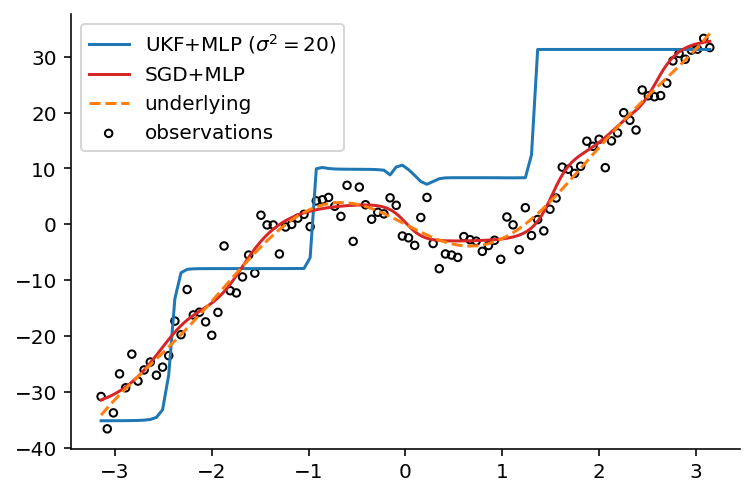

In [963]:
plt.plot(x, fx_p(x, mu_hist[-1, :, None]), label=f"UKF+MLP $(\sigma^2={σ2})$")
plt.plot(xtest, yhat_test, c="tab:red", label="SGD+MLP")
plt.plot(x, f(x), label="underlying", linestyle="--")
plt.scatter(x, y, s=14, c="none", edgecolor="black", label="observations")
plt.legend()

In [931]:
def construct_params(params_flat, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    return params

In [932]:
ukf_params = construct_params(mu_hist[-1], shapes, treedef)

In [933]:
loss(ukf_params)

DeviceArray(67.17924, dtype=float32)

In [806]:
ukf = UnscentedKalmanFilter(fz, fx_vmap, Sigma_hist[-1,...], R, alpha, beta, kappa)
mu_hist, Sigma_hist = ukf.filter(mu_hist[-1, :], y[:, None], x)

In [649]:
def forward_mlp(X, params_flat, model, shapes, treedef):
    indices = jnp.array([np.prod(s) for s in shapes]).cumsum()
    split_reconstruction = jnp.array_split(params_flat, indices)
    split_reconstruction = [arr.reshape(shape) for arr, shape in zip(split_reconstruction, shapes)]
    params = jax.tree_unflatten(treedef, split_reconstruction)
    yhat = model.apply(params, X)
    return yhat

In [650]:
params_test = all_params * jnp.ones((1, 283))
fx_p(x[1, None], params_test[:, 1])

DeviceArray([[-30.987345]], dtype=float32)

In [653]:
fx_vmap = jax.vmap(fx_p, in_axes=[None, 1])
fx_vmap(x[1, None], params_test).shape

(283, 1, 1)

# EKF method

## Jacobian of the MLP

In [284]:
class D_MLP1D(nn.Module):
    n_hidden: int
        
    def setup(self):
        self.model = MLP1D(self.n_hidden)
    
    def __call__(self, x):
        return jax.jacfwd(self.model)(x)

In [295]:
X = normal(key2, (100, 2))

In [296]:
key = PRNGKey(314)
key1, key2 = split(key, 2)


n_hidden = 10
model = MLP1D(n_hidden)
D_model = MLP1D(n_hidden)

params = model.init(key1, X)
yhat = model.apply(params, X)

In [303]:
x.shape

(100,)

In [301]:
D_model.apply(params, X).shape

(100, 1, 1)

## References
* https://github.com/google/flax/issues/735
* https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html